### Feature Engineering & Extraction der maritimen Features

In [1]:
import sys
sys.path = ["", ".."] + sys.path[1:]

In [2]:
import pathlib
import pandas as pd
import numpy as np
import joblib
import aisfeel
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

/home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


Karp

In [3]:
data = pathlib.Path("/space/user/hdreesmann/")
cargo_tanker = data / "cleaned_weather_cargo_tanker"

In [4]:
cluster = LocalCluster(n_workers=26, 
                       threads_per_worker=2,
                       memory_limit='32GB')
cluster

LocalCluster(24676dce, 'tcp://127.0.0.1:33897', workers=26, threads=52, memory=832.00 GB)

In [5]:
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:33897' processes=26 threads=52, memory=832.00 GB>

In [1]:
cluster.close()

NameError: name 'cluster' is not defined

In [7]:
df = dd.read_parquet(cargo_tanker).persist()

In [8]:
df.head()

timestamp type_of_mobile       mmsi   latitude  longitude  \
34253 2021-01-01 07:21:09        Class A  229025000  56.837205  12.409410   
34253 2021-01-18 15:04:08        Class A  244874000  54.366848  10.161980   
34253 2021-01-22 02:43:09        Class A  244874000  54.683473  15.416632   
34253 2021-01-23 22:48:08        Class A  538007101  55.513237  10.881970   
34253 2021-01-24 01:41:58        Class A  538007101  55.986945  11.068172   

          navigational_status  rot   sog    cog  heading  ...  \
34253  Under way using engine  0.0   0.1  144.8    164.0  ...   
34253  Under way using engine  0.0   3.5  238.5    238.0  ...   
34253  Under way using engine  0.0  16.7   82.6     83.0  ...   
34253  Under way using engine -0.7  10.9  332.9    331.0  ...   
34253  Under way using engine -0.4  11.8   48.0     46.0  ...   

      sea_surface_wave_stokes_drift_x_velocity_unit_m_s-1  \
34253                                              -0.02    
34253                                               0.02    
34253                                               0.03    
34253                                               0.01    
34253                                               0.01    

      sea_surface_primary_swell_wave_mean_period_unit_s  \
34253                                              2.88   
34253                                              2.22   
34253                                              4.25   
34253                                              2.60   
34253                                              3.56   

       sea_surface_wave_stokes_drift_y_velocity_unit_m_s-1  \
34253                                               0.04     
34253                                               0.04     
34253                                               0.11     
34253                                               0.05     
34253                                               0.07     

       sea_surface_wave_significant_height_unit_m  \
34253                                        0.45   
34253                                        0.27   
34253                                        1.14   
34253                                        0.37   
34253                                        0.57   

       sea_surface_wind_wave_mean_period_unit_s  \
34253                                      2.14   
34253                                      2.01   
34253                                      3.76   
34253                                      2.37   
34253                                      2.77   

      sea_surface_secondary_swell_wave_significant_height_unit_m  \
34253                                               0.05           
34253                                               0.02           
34253                                               0.08           
34253                                               0.05           
34253                                               0.07           

       northward_sea_water_velocity_unit_m_s-1  \
34253                                 0.231330   
34253                                 0.025025   
34253                                 0.062868   
34253                                 0.005493   
34253                                -0.052492   

       sea_water_potential_temperature_unit_degrees_c  \
34253                                        5.207038   
34253                                        2.757011   
34253                                        5.368176   
34253                                        3.430861   
34253                                        4.254860   

       eastward_sea_water_velocity_unit_m_s-1  \
34253                               -0.212409   
34253                                0.110477   
34253                                0.008545   
34253                                0.005493   
34253                                0.071413   

       sea_surface_height_above_geoid_unit_m  
34253                              -0.389416  

Filtern der Daten: 1. <5 Knoten SOG, 2. Default Outlier Werte, 3. Navstatus moored und anchored 4. Missing data, Wind und Strömungsgeschwindigkeit werden in Richtungswinkel und Kraft umgerechnet: Speed=|V| = π /180 × √ u2 + v2, Richtung= θ = 180 + 180 /π atan2(u, v).
Berechnung Durchschnittsgeschwindigkeit, Labeling "Vessel is sailing"/"Vessel has stopped"
Trajectory generation aus den AIS-Daten; Filtern der Daten: 1. Fehlende IMO,MMSI,DWT,speed,course 2. Falsche MMSI (nicht 9 stellige nummer), 3. Duplikate
1. Datenfusion basierend auf timestamps: Tweets oder Beschreibende Statements mit AIS Koordinaten die Zeitlich am nähesten sind. 2. manuelles Labeln von Rettungs Trajektorien
Lade- und Entladehafen abschätzung über draft info aus AIS Draft +-20% max change of draft at each stopping point -> be-/entladung; 1. Interpolate missing speed and draft with value immediatley before 2. generate Geohash(4) and Geohash(7); 3. staying points: vessel in same Geohash 4 >5h ->  extract staying start and endtime 4. Most counted draft during staying -> before-arrival draft -> associate Geohash 7 mit längster staying period mit berthing/mooring point & assume draft of next staying point (Geohash 4 as post starting draft 5. Export/Import Berth based on pre-arrival and post-starting draft
1. Umwandlung von COG(C)  und Speed(v) in Bewegungsvektoren (Vx,Vy): Vx=cos(m)*v, Vy=sin(m)*v mit m = {90-C (0<=C<90), 90+C (90<=C<180), 270-C (180<=C<270), 270+C (270<=C<360) 2. Interpolation der Position mit den Bewegunsvektoren 3. Schiffskateorien 4. Längen normalisierung (schifflänge/länge des längsten schiffs)
Berechnung des  Energy Efficiency Operational Indicator (EEOI); Motorkraft berechnung mittels annäherungsformel; Korrektion des Speed wertes um die Strömungsgeschwindigkeit (V = Wurzel((uship-ucurrent)^2+(vship-vcurrent)^2)
Codierung der Windrichtung

Four-Hot Encoding (lon,lat,sog,cog) -> geometrie von Zeit Dimension trennen -> 4 One-Hot Vektor concatenated -> Auflösung der Werte lat,lon: 0.01° (ca 1km), sog: 1 Knoten, cog: 5°, Voyages: Split falls 4h zwischen 2 aufeinanderfolgenden AIS Nachrichten, Lange voyages in kleinere 4-24h; Resampling auf 10 mins
Windowing der Daten

Berechnung von: Acceleration, DayOfWeek, HourOfDay, CourseChangeRate, HeadingChangeRate,
NumCloseInteractions, NumLocalInteractions, ClosestType, ClosestSpeed, ClosestCourse, ClosestDistance, SinceDawn, SinceDusk
3rd Tier Lat-t2, Lon-t2, Course-t2, Heading-t2, Speed-t2, Acceleration-t2"



In [9]:
# import importlib
# importlib.reload(aisfeel)

### Vektor darstellungen
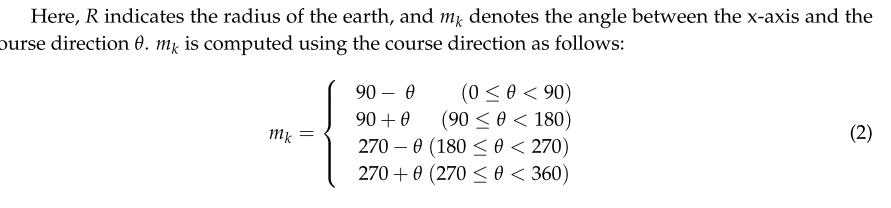

Vx = cos(mk)·v, Vy= sin(mk)·v


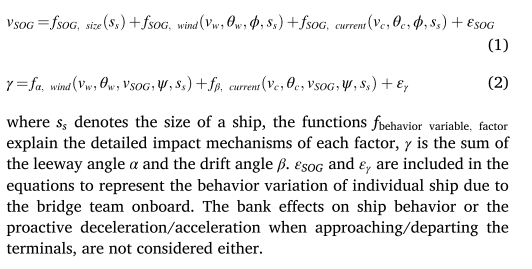



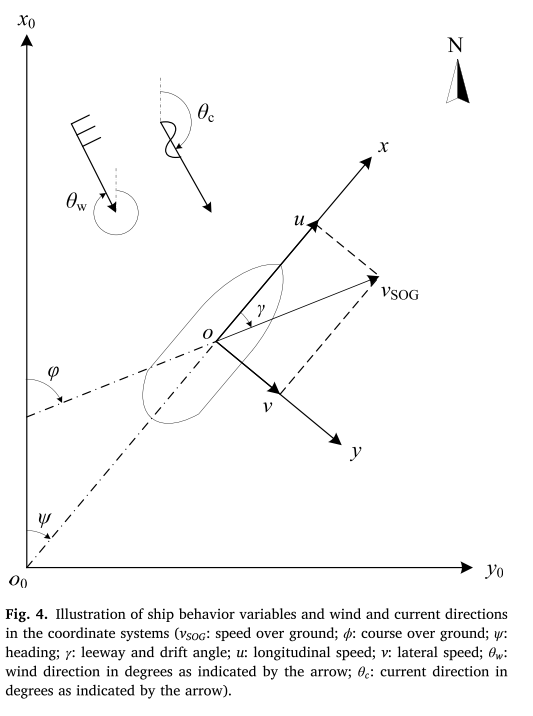

In [10]:
before = set(df.columns)

In [11]:
df = df.pipe(aisfeel.extract_all)

In [12]:
set(df.columns)-before

{'cargo_type_Category OS',
 'cargo_type_Category X',
 'cargo_type_Category Y',
 'cargo_type_Category Z',
 'cargo_type_No additional information',
 'cargo_type_Reserved for future use',
 'drift_angle',
 'h3_res_4',
 'h3_res_6',
 'h3_res_7',
 'h3_res_8',
 'h3_res_9',
 'is_sailing',
 'navigational_status_Aground',
 'navigational_status_Constrained by her draught',
 'navigational_status_Not under command',
 'navigational_status_Reserved for future amendment [WIG]',
 'navigational_status_Reserved for future use [11]',
 'navigational_status_Reserved for future use [13]',
 'navigational_status_Restricted maneuverability',
 'navigational_status_Under way sailing',
 'navigational_status_Under way using engine',
 'navigational_status_Unknown value',
 'norm_length',
 'norm_width',
 'ship_type_Cargo',
 'ship_type_Tanker',
 'u_ship',
 'v_ship',
 'vx',
 'vy'}

### Saving the results

In [14]:
df.to_parquet(data / "cargo_tanker_features",schema="infer")